In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import os.path as path
import matplotlib.ticker as ticker

from scipy.integrate import simps, trapz


import matplotlib as mpl
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix',
    'xtick.direction' : 'in' ,
    'xtick.labelsize' : 13 ,
    'xtick.top' : True ,
    'ytick.direction' : 'in' ,
    'ytick.labelsize' : 13 ,
    'ytick.right' : True ,
    'axes.labelsize' : 16,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 1.5,
    'savefig.dpi' : 600, 
    'savefig.bbox' : 'tight'
})

In [2]:
!pwd

/home/hyejin/Desktop/my_git/DMFT_NN/2_nn


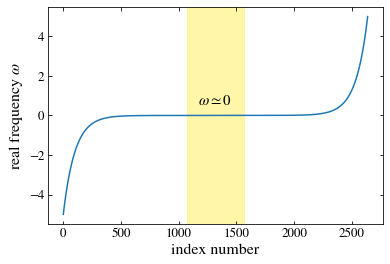

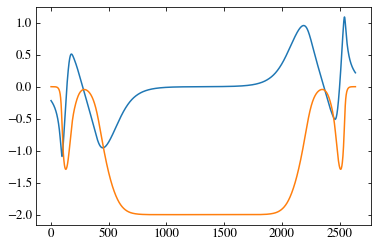

In [3]:
D = 1
out_node = 2
directory = '../1_dmftsolver/NRG'

w, A,Gr,Gi,_,_,_,_,_,_ = np.loadtxt(f'{directory}/Bethe_14_beta10000/Bethe-{2.5:.3f}.dat', \
                       unpack = True, dtype = 'complex128')
plt.plot(w.real)
plt.ylabel(r'real frequency $\omega$')
plt.xlabel('index number')
plt.axvspan(1319-250, 1319+250, alpha=0.5, color='#ffee52')
plt.annotate(r'$\omega\simeq0$', xy=(0.5, 0.55), xycoords = 'axes fraction', fontsize=15, ha='center')
#plt.savefig('index2w.png')
plt.show()


plt.plot(Gr.real)
plt.plot(Gi.real)

### ED data

In [6]:
def EDbath(e, V):
    return np.array([np.sum(V**2/(1j*omega[i]-e)) for i in range (aa)])

aa = 10000
omega = np.pi/aa * (2*np.arange(aa)+1)

In [12]:
beta = 100
directory1 = '../1_dmftsolver/ED'
up_num = 211
dn_num = 211
U = np.array([0.01*i for i in range(50, 501)])
U1_ed = np.zeros(up_num, dtype = 'float64')
U2_ed = np.zeros(dn_num, dtype = 'float64')
U_c1_ed, U_c2_ed = 2.4, 2.93


n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{u:.2f}')==False: continue
    U1_ed[n] = u
    n += 1
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory1}/ED_41_beta{beta:d}/checkpoint-{u:.2f}')==False: continue
    U2_ed[n] = u
    n += 1

x_test_ed = np.zeros((len(U1_ed)+len(U2_ed), 10000), dtype = 'float64')
UU1 = U1_ed[U1_ed<2.3]
UU2 = U2_ed[U2_ed>2.8]
x = np.zeros((len(UU1)+len(UU2), 10000), dtype = 'float64')

for i,u in enumerate(U1_ed):
    a = np.loadtxt(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    x_test_ed[i][:aa] = EDbath(e,V).imag
for i,u in enumerate(U2_ed):
    a = np.loadtxt(f'{directory1}/ED_41_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    x_test_ed[i+len(U1_ed)][:aa] = EDbath(e,V).imag
    
for i,u in enumerate(UU1):
    a = np.loadtxt(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    x[i][:aa] = EDbath(e,V).imag
for i,u in enumerate(UU2):
    a = np.loadtxt(f'{directory1}/ED_41_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    x[i+len(UU1)][:aa] = EDbath(e,V).imag
    
x_test_ed = -torch.FloatTensor(x_test_ed)
x = -torch.FloatTensor(x)

y_temp1 = np.array(U1_ed < U_c2_ed)
y_temp2 = np.array(U2_ed < U_c1_ed)
y_temp = np.concatenate([y_temp1, y_temp2])
y_test_ed = np.stack([y_temp, ~y_temp], axis = 1)
y_test_ed = torch.FloatTensor(y_test_ed)

y_temp1 = np.array(UU1 < U_c2_ed)
y_temp2 = np.array(UU2 < U_c1_ed)
y_temp = np.concatenate([y_temp1, y_temp2])
y = np.stack([y_temp, ~y_temp], axis = 1)
y = torch.FloatTensor(y)
UU_ed = np.concatenate((U1_ed, U2_ed))

def divide(x_, y_):
    mask = np.random.rand(len(x_)) < 0.9  # train : val = 4 : 1
    x_train, x_val = x_[mask], x_[~mask]
    y_train, y_val = y_[mask], y_[~mask]
    return x_train, x_val, y_train, y_val
x_train, x_val, y_train, y_val = divide(x, y)

(0.0, 0.12)

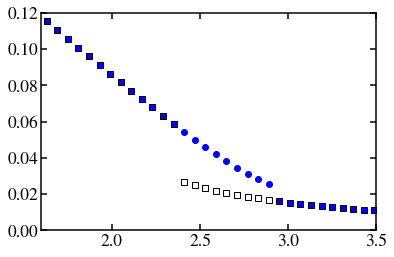

In [69]:
docc1 = np.zeros_like(U1_ed)
docc2 = np.zeros_like(U2_ed)
for i,u in enumerate(U1_ed):
    a = np.loadtxt(f'{directory1}/ED_14_beta{beta:d}/result-{u:.2f}', delimiter=' ', usecols=[1])
    docc1[i] = a[1]
for i,u in enumerate(U2_ed):
    a = np.loadtxt(f'{directory1}/ED_41_beta{beta:d}/result-{u:.2f}', delimiter=' ', usecols=[1])
    docc2[i] = a[1]
plt.plot(U1_ed[::6], docc1[::6], 'bo')
plt.plot(U2_ed[::6], docc2[::6], 'ks', mfc='none')
plt.xlim(1.6, 3.5)
plt.ylim(0, 0.12)

In [57]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import numpy as np
from matplotlib import rc

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import os.path as path
import matplotlib.ticker as ticker
from scipy.integrate import simps, trapz

import matplotlib as mpl
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix',
    'xtick.direction' : 'in' ,
    'xtick.labelsize' : 17.5 ,
    'xtick.top' : True ,
    'xtick.major.width' : 1.5,
    'xtick.major.size' : 6,
    'ytick.direction' : 'in' ,
    'ytick.labelsize' : 17.5 ,
    'ytick.right' : True ,
    'ytick.major.width' : 1.5,
    'ytick.major.size' : 6,
    'axes.labelsize' : 18,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 2,
    'savefig.dpi' : 600, 
    'savefig.bbox' : 'tight',
    'axes.linewidth' : 1.5,
})
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [15]:
class Net(nn.Module):
    def __init__(self, activate = None):
        super(Net, self).__init__()
        self.W1 = nn.Linear(10000, out_node)#, bias=False)
        self.b1 = nn.Linear(out_node, 1)#, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()
        #self.W1.weight.data.fill_(0)
        nn.init.uniform_(self.W1.weight.data, -0.01, 0.01)
        self.b1.weight.data.fill_(0)
        
        

    def forward(self, x):
        x = self.W1(x)+self.b1.weight.data
        return self.sig(x)

    def loss1(self, output, y, reg): # regularization l1
        regular = reg*(torch.norm(self.W1.weight.data, p=1))
        return F.binary_cross_entropy(output, y) + regular # cross entropy loss
    def loss2(self, output, y, reg): # regularization l2
        regular = reg*(torch.norm(self.W1.weight.data)**2)
        return F.binary_cross_entropy(output, y) + regular # cross entropy loss

    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)

In [39]:
learning_rate = 1e-3
reg = 1e-4
func = nn.Sigmoid
model = Net(activate = func)
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
n_epochs = 2000
train_loss, val_loss, test_acc = np.ones(n_epochs+1), np.ones(n_epochs+1), np.ones(n_epochs+1)
for epoch in range (n_epochs+1):
    loss = model.loss1(model.forward(x_train), y_train, reg)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    valid_loss = model.loss1(model.forward(x_val), y_val, reg).item()
    t_acc = model.accuracy(model.forward(x_test_ed), y_test_ed)
    train_loss[epoch], val_loss[epoch], test_acc[epoch] = loss.item(), valid_loss, t_acc

    if epoch%int(n_epochs/10) == 0:
        print('epoch = %d, training loss = %.6f, valid loss = %.6f, accuracy = %.8f' \
                %(epoch, loss.item(), valid_loss, t_acc))

epoch = 0, training loss = 0.753459, valid loss = 0.706523, accuracy = 0.28909953
epoch = 200, training loss = 0.239377, valid loss = 0.254943, accuracy = 0.98815166
epoch = 400, training loss = 0.161291, valid loss = 0.173822, accuracy = 0.98578199
epoch = 600, training loss = 0.120189, valid loss = 0.130528, accuracy = 0.98578199
epoch = 800, training loss = 0.095800, valid loss = 0.104572, accuracy = 0.98578199
epoch = 1000, training loss = 0.079983, valid loss = 0.087598, accuracy = 0.98578199
epoch = 1200, training loss = 0.069025, valid loss = 0.075756, accuracy = 0.98578199
epoch = 1400, training loss = 0.061047, valid loss = 0.067084, accuracy = 0.98578199
epoch = 1600, training loss = 0.055012, valid loss = 0.060488, accuracy = 0.98578199
epoch = 1800, training loss = 0.050307, valid loss = 0.055322, accuracy = 0.98578199
epoch = 2000, training loss = 0.046547, valid loss = 0.051177, accuracy = 0.98578199


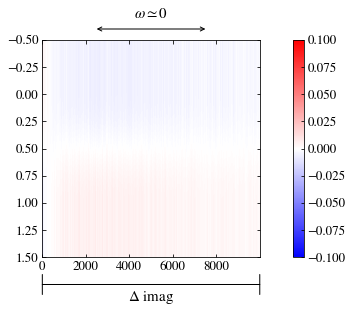

In [40]:
fig, ax = plt.subplots(1, 1, figsize = (12, 4))
op = {'vmin': -0.1, 'vmax': 0.1}
OP = {'vmin': -1.5, 'vmax': 1.5}
im1 = ax.imshow(np.array(model.W1.weight.data), aspect=10000/2, cmap='bwr', **op)
#im2 = ax[1].imshow(Weight*number, aspect=2000/h_node, cmap='bwr', **OP)
import matplotlib.ticker as ticker
#ax[1].xaxis.set_major_locator(ticker.MultipleLocator(500))
#ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: r'%.1f'%((x-1000)/200)))
#ax[1].set_xlabel(r'$\omega$')
ax.annotate('', xy=(0, -0.125), xytext=(1, -0.125), xycoords='axes fraction',\
               ha='center', va="center", arrowprops={'arrowstyle':'|-|', 'shrinkA':0, 'shrinkB':0})

ax.annotate('', xy=(0.25, 1.05), xytext=(0.75, 1.05), xycoords='axes fraction',\
               ha='center', va="center", arrowprops={'arrowstyle':'<->', 'shrinkA':0, 'shrinkB':0})
ax.annotate(r'$\omega\simeq0$', xy=(0.5, 1.1), xycoords = 'axes fraction', fontsize=15, ha='center')
ax.annotate(r'$\Delta$ imag', xy=(0.5, -0.2), xycoords = 'axes fraction', fontsize=15, ha='center')

cd = plt.colorbar(im1, ax=ax)
#cd = plt.colorbar(im2, ax=ax[1])
#plt.savefig('NN_Weight_u0.001_10.png')
plt.show()

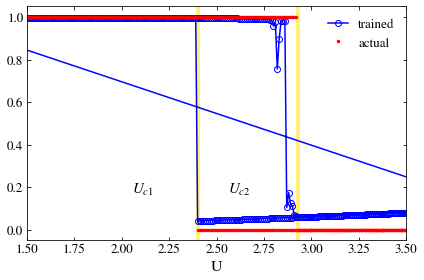

In [41]:
plt.axvline(U_c1_ed, c = '#ffee52', lw = '4',  alpha=0.8)
plt.axvline(U_c2_ed, c = '#ffee52', lw = '4',  alpha=0.8)
plt.plot(UU_ed, model.forward(x_test_ed).data[:,0], 'bo-', mfc='none', label = 'trained')
#plt.plot(UU_ed, x_test_ed[:,0]/torch.max(x_test_ed[:, 0]), 'g^', ms=6, mfc='none', label=r'$Im\Delta(\omega=0)$')
#plt.plot(UU_ed, np.average(x_test_ed[:,0:150], axis=1)/np.max(np.average(x_test_ed[:,0:150], axis=1)), 'g^', ms=6, mfc='none', label=r'$Im\Delta(\omega=0)$')
plt.plot(UU_ed, y_test_ed[:,0], 'r.', ms = 5, label = 'actual')
plt.xlim(1.5, 3.5)
plt.xlabel('U')
plt.annotate(r'$U_{c1}$', xy=(0.305, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
plt.annotate(r'$U_{c2}$', xy=(0.56, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
#plt.title(r'$\beta=100$', fontsize=16)
plt.legend()

plt.tight_layout(w_pad=1.5)
#plt.savefig('LogisticRegression_outputcubic_u0.001.png')

## Saving results

In [625]:
model.W1.weight.data.shape

(torch.Size([2, 2638]), (2, 2001), (2, 10000))

In [35]:
np.savetxt('frozen_mat/iw_LR_W1.txt', np.array(model.W1.weight.data))
np.savetxt('frozen_mat/iw_LR_b1.txt', np.array(model.b1.weight.data))